In [8]:
from dataloading import load_tira_asr
import pandas as pd
from unidecode import unidecode
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# using this until I figure out how to set jupyter working dir in PyCharm
import os
project_dir = '/Users/markjos/projects/tira_kws'
os.chdir(project_dir)

In [6]:
# constants
merged_csv = 'data/labels/keyphrases_rewritten_merges.csv'
keyphrase_csv = 'data/labels/keyphrases_list.csv'
cer_matrix_path = 'data/labels/keyphrase_cer_matrix.csv'

In [9]:
ds=load_tira_asr()
ds

Dataset({
    features: ['audio', 'transcription', 'rewritten_transcript', 'translation'],
    num_rows: 20480
})

## Merged transcripts
Find instances where FST normalization caused several dissimilar hand-transcribed sentences to merge and save as a .csv file.

In [10]:
colmap = {'transcription': 'eaf_text', 'rewritten_transcript': 'fst_text'}
cols_to_drop = set(ds.column_names)-set(colmap.keys())
ds_noaudio = ds.remove_columns(cols_to_drop)
df = ds_noaudio.to_pandas()
df = df.rename(columns=colmap)
df.head()

,eaf_text,fst_text
0,àprí jɜ̀dí ðáŋàlà,àpɾí jàdí ðáŋàlà
1,àprí jɜ̀dí ðáŋàlà,àpɾí jàdí ðáŋàlà
2,àprí jə̀və̀lɛ̀ðɔ́ ðáŋàlà,àpɾí jə̀və̀lɛ̀ðɔ́ ðáŋàlà
3,àprí jə̀və̀lɛ̀ðɔ́ ðáŋàlà,àpɾí jə̀və̀lɛ̀ðɔ́ ðáŋàlà
4,àprí jə̀və̀lɛ̀ðɔ́ ðáŋàlà,àpɾí jə̀və̀lɛ̀ðɔ́ ðáŋàlà


In [11]:
fst_to_eaf = {}
fst_unique = df['fst_text'].unique().tolist()
eaf_unique = df['eaf_text'].unique().tolist()
for fst_text in tqdm(fst_unique):
    mask = df['fst_text'] == fst_text
    eaf_text = df.loc[mask, 'eaf_text'].unique().tolist()
    fst_to_eaf[fst_text] = eaf_text
len(fst_unique), len(eaf_unique)

100%|██████████| 8350/8350 [00:17<00:00, 483.89it/s]


(8350, 9399)

In [7]:
unique_phrase_df = df.drop_duplicates(subset=['eaf_text'])
print(df.shape, unique_phrase_df.shape)

unique_phrase_df['num_eaf_variants'] = unique_phrase_df['fst_text'].map(lambda x: len(fst_to_eaf[x]))
unique_phrase_df = unique_phrase_df.sort_values('num_eaf_variants', ascending=False)
unique_phrase_df=unique_phrase_df.set_index('fst_text')
unique_phrase_df.head()

(20480, 2) (9399, 2)


/tmp/ipykernel_27334/3299219906.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_phrase_df['num_eaf_variants'] = unique_phrase_df['fst_text'].map(lambda x: len(fst_to_eaf[x]))


,eaf_text,num_eaf_variants
fst_text,,
láló və́lɛ̀ðà nd̪ɔ̀bà,lálóvə́lɛ̂ðǎ ndɔ̀bà,8
láló və́lɛ̀ðà nd̪ɔ̀bà,lálóvə́lɛ̂ðà ndɔ̀bàgɛ̀,8
láló və́lɛ̀ðà nd̪ɔ̀bà,lálóvə́lɛ̂ðá nd̪ɔ̀bàgɛ̀,8
láló və́lɛ̀ðà nd̪ɔ̀bà,lǎlóvə́lɛ̂ðà nd̪ɔ̀bàgɛ̀,8
láló və́lɛ̀ðà nd̪ɔ̀bà,lálóvə́lɛ̀ðà nd̪ɔ̀bàgɛ̀,8


In [4]:
# load pre-generated unique phrase df
eaf_unique_df = pd.read_csv(merged_csv)
eaf_unique_df.head()

,index,fst_text,token_count,num_easy,num_medium,num_hard,is_keyphrase
0,0,abr ɲá t̪ə́vìnɛ̀,1,0,0,0,False
1,1,abuð,4,0,0,0,False
2,2,abuð t̪ə̀mànì,2,0,0,0,False
3,3,abuð ɲáŋgɔ̂,4,0,0,0,False
4,4,abuð ɲáŋú t̪ə̀mànì,3,0,0,0,False


How many unique EAF strings do we have per FST-normalized string?

In [5]:
eaf_unique_df['num_eaf_variants'].value_counts()

KeyError: 'num_eaf_variants'

Ignore EAF text, make a `DataFrame` with only unique FST strings

In [20]:
unique_phrase_df = eaf_unique_df.drop(columns='eaf_text')
unique_phrase_df = unique_phrase_df.groupby('fst_text', as_index=False)[('token_count')].sum()
unique_phrase_df.head()

,fst_text,token_count
0,abr ɲá t̪ə́vìnɛ̀,1
1,abuð,4
2,abuð t̪ə̀mànì,2
3,abuð ɲáŋgɔ̂,4
4,abuð ɲáŋú t̪ə̀mànì,3


In [23]:
all_phrases = unique_phrase_df['fst_text'].unique().tolist()
all_phrases[:10], len(all_phrases)

(['abr ɲá t̪ə́vìnɛ̀',
  'abuð',
  'abuð t̪ə̀mànì',
  'abuð ɲáŋgɔ̂',
  'abuð ɲáŋú t̪ə̀mànì',
  'aj íŋgá dùɾɔ́ kə́nɔ̀nà ìmìdánŋwɔ́',
  'aj íŋgá dúɾɔ̀ ká nɔ́nà ìmìdánŋwɔ́',
  'aj íŋgá dúɾɔ̀ kə́nɔ̀nà ìmìdánŋwɔ́',
  'aj íŋgá úrɔ̀ ká nɔ́nà ìmìdánŋwɔ́',
  'apit̪'],
 8322)

## Keyphrase selection
Visualize keyphrases with 10 or more tokens and select the set to be used for KWS.

In [11]:
# commenting out since we're loading `unique_phrase_df` pre-generated w/ `token_count` column
# keyphrase_counts = df['fst_text'].value_counts()
# keyphrase_counts.head(10)

In [10]:
# unique_phrase_df['token_count'] = keyphrase_counts
# unique_phrase_df.head()

,fst_text,eaf_text,num_eaf_variants,token_count
0,láló və́lɛ̀ðà nd̪ɔ̀bà,lálóvə́lɛ̂ðǎ ndɔ̀bà,8,20
1,láló və́lɛ̀ðà nd̪ɔ̀bà,lálóvə́lɛ̂ðà ndɔ̀bàgɛ̀,8,20
2,láló və́lɛ̀ðà nd̪ɔ̀bà,lálóvə́lɛ̂ðá nd̪ɔ̀bàgɛ̀,8,20
3,láló və́lɛ̀ðà nd̪ɔ̀bà,lǎlóvə́lɛ̂ðà nd̪ɔ̀bàgɛ̀,8,20
4,láló və́lɛ̀ðà nd̪ɔ̀bà,lálóvə́lɛ̀ðà nd̪ɔ̀bàgɛ̀,8,20


In [48]:
keyphrase_mask = unique_phrase_df['token_count'] >= 10
unique_phrase_df['is_keyphrase'] = keyphrase_mask
high_freq_phrases = unique_phrase_df[keyphrase_mask]['fst_text'].tolist()
high_freq_phrases[:5], unique_phrase_df[keyphrase_mask].shape

(['aŋ və́lɛ̀ðɛ̀ t̪ə́mànì',
  'aɾt̪ və́lɛ́ðɔ́ èdɔ̀ɽɔ̀ t̪ə́mànì',
  'àbr̀á t̪ə́mànì',
  'àn lə́vàvɾì lá ɛ́làɽà dɔ́ŋðɛ̀',
  'àn ɔ́ɾɔ́ kə́ðìɲɔ́ muðɔ'],
 (378, 6))

We have 143 unique keyphrases with 10 or more occurrences. We'll define these as our keyword set.

In [35]:
pd.Series(unique_phrase_df[keyphrase_mask]['fst_text'].str.len()).describe()

count    378.000000
mean      21.746032
std        9.049762
min        3.000000
25%       16.000000
50%       22.000000
75%       27.000000
max       51.000000
Name: fst_text, dtype: float64

Get negative keyphrases based on CER from positive keyphrase.

First, make a distance matrix showing pairwise CER between keyphrases and all sentences.
Row

In [36]:
from jiwer import cer, process_characters
import numpy as np

cer_matrix = np.zeros((keyphrase_mask.sum(), len(all_phrases)), dtype=int)
for i, phrase1 in tqdm(enumerate(high_freq_phrases), total=len(high_freq_phrases)):
    for j, phrase2 in enumerate(all_phrases):
        dist = cer(phrase1, phrase2)
        cer_matrix[i, j] = dist
cer_matrix[:5,:5]

100%|██████████| 378/378 [05:08<00:00,  1.23it/s]


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

Now, for each positive keyphrase, bucket negative keyphrases based on the ratio of the edit distance to the keyphrase's length.
Then sample 30 keywords from 0-33% edit distance/length (hard), 33-66% (medium) and 66-100% (easy)


In [44]:
unique_phrase_df['num_easy'] = 0
unique_phrase_df['num_medium'] = 0
unique_phrase_df['num_hard'] = 0

for keyphrase_idx, keyphrase in enumerate(high_freq_phrases):
    keyphrase_len = len(keyphrase)

    dists_to_keyphrase = cer_matrix[keyphrase_idx, :]

    easy_mask = dists_to_keyphrase > 0.67
    medium_mask = (dists_to_keyphrase <= 0.67) & (dists_to_keyphrase > 0.33)
    hard_mask = dists_to_keyphrase <= 0.33

    curr_keyphrase_mask = unique_phrase_df['fst_text'] == keyphrase
    unique_phrase_df.loc[curr_keyphrase_mask, 'num_easy'] = easy_mask.sum()
    unique_phrase_df.loc[curr_keyphrase_mask, 'num_medium'] = medium_mask.sum()
    unique_phrase_df.loc[curr_keyphrase_mask, 'num_hard'] = hard_mask.sum()

    # print(f'Keyphrase: "{keyphrase}" (len={keyphrase_len})')
    # print(f'  Easy: {np.sum(easy_mask)}')
    # print(f'  Medium: {np.sum(medium_mask)}')
    # print(f'  Hard: {np.sum(hard_mask)}')

In [49]:
unique_phrase_df[keyphrase_mask]['num_hard'].describe()

count     378.000000
mean     4643.100529
std      2543.509281
min         5.000000
25%      2619.750000
50%      4930.500000
75%      6826.500000
max      8300.000000
Name: num_hard, dtype: float64

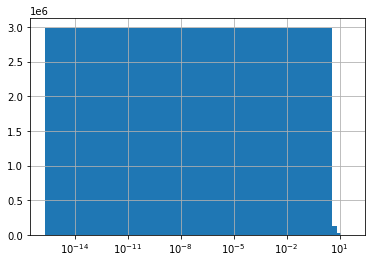

In [63]:
fig = pd.Series(cer_matrix.flatten()).hist()
plt.xscale('log')
plt.show()

In [65]:
unique_phrase_df.to_csv(merged_csv, index_label='index')
np.save(cer_matrix_path, cer_matrix)

NameError: name 'cer_matrix_path' is not defined